## File created by Reid Wyde


### Last updated 10.29.19

### TODO


#### short term

verify that get_Sh is working correctly

calibrate tau_h and delta_h on group 3

calibrate tau_d, delta_d, tau_dh, delta_dh on 2, 4, 5 and 6

Delay term


#### mid term


visualization on gelman rubin

investigate maximum likelihood parameter sample



#### long term


configure theano for multiple cores // windows issue, not possible right now



# Data driven growth models for Adjuvant Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

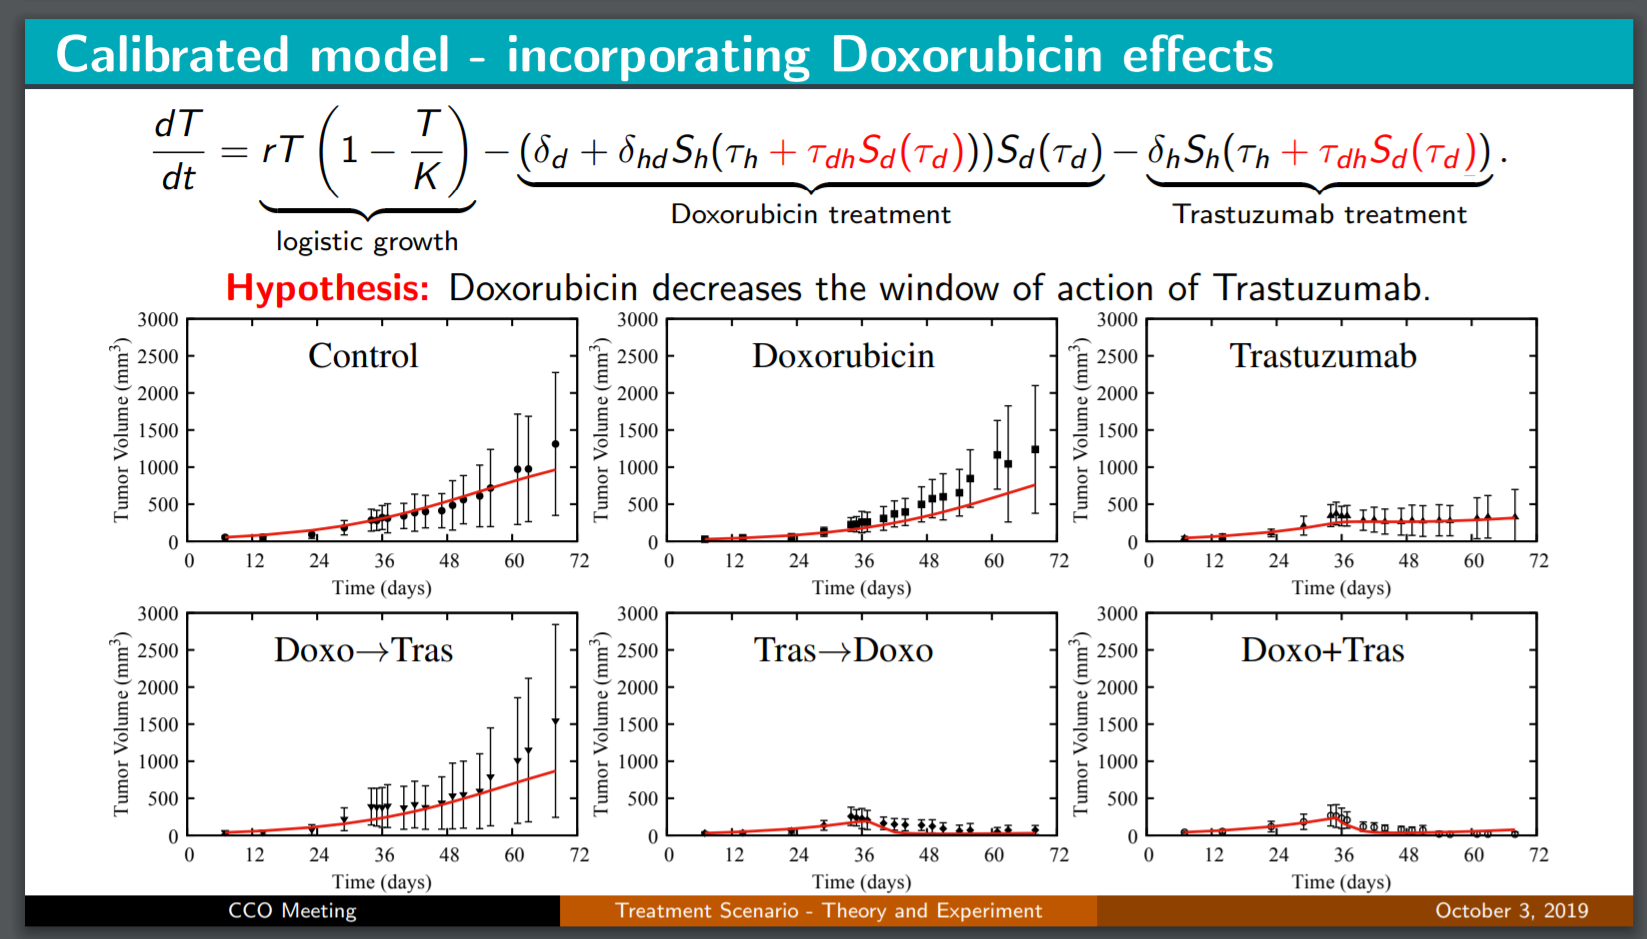

### Mathematical models of tumor growth, provided by Dr. Ernesto Lima, The Center for Computational Oncology at The University of Texas, 2019. 

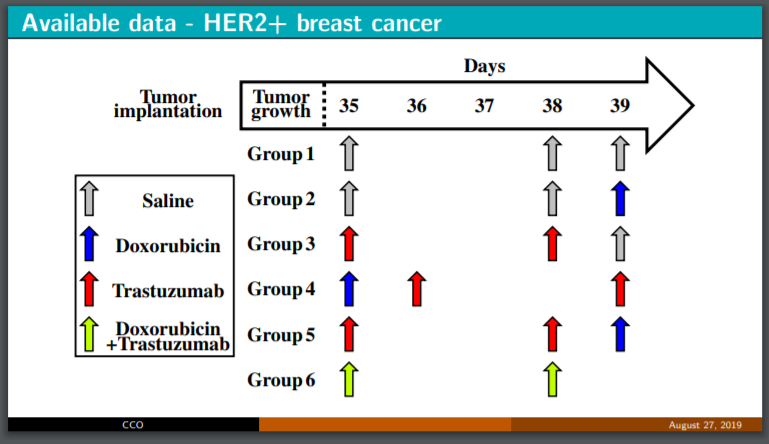

### Other growth models for potential investigation, from Skehan et al. 1984


<div>
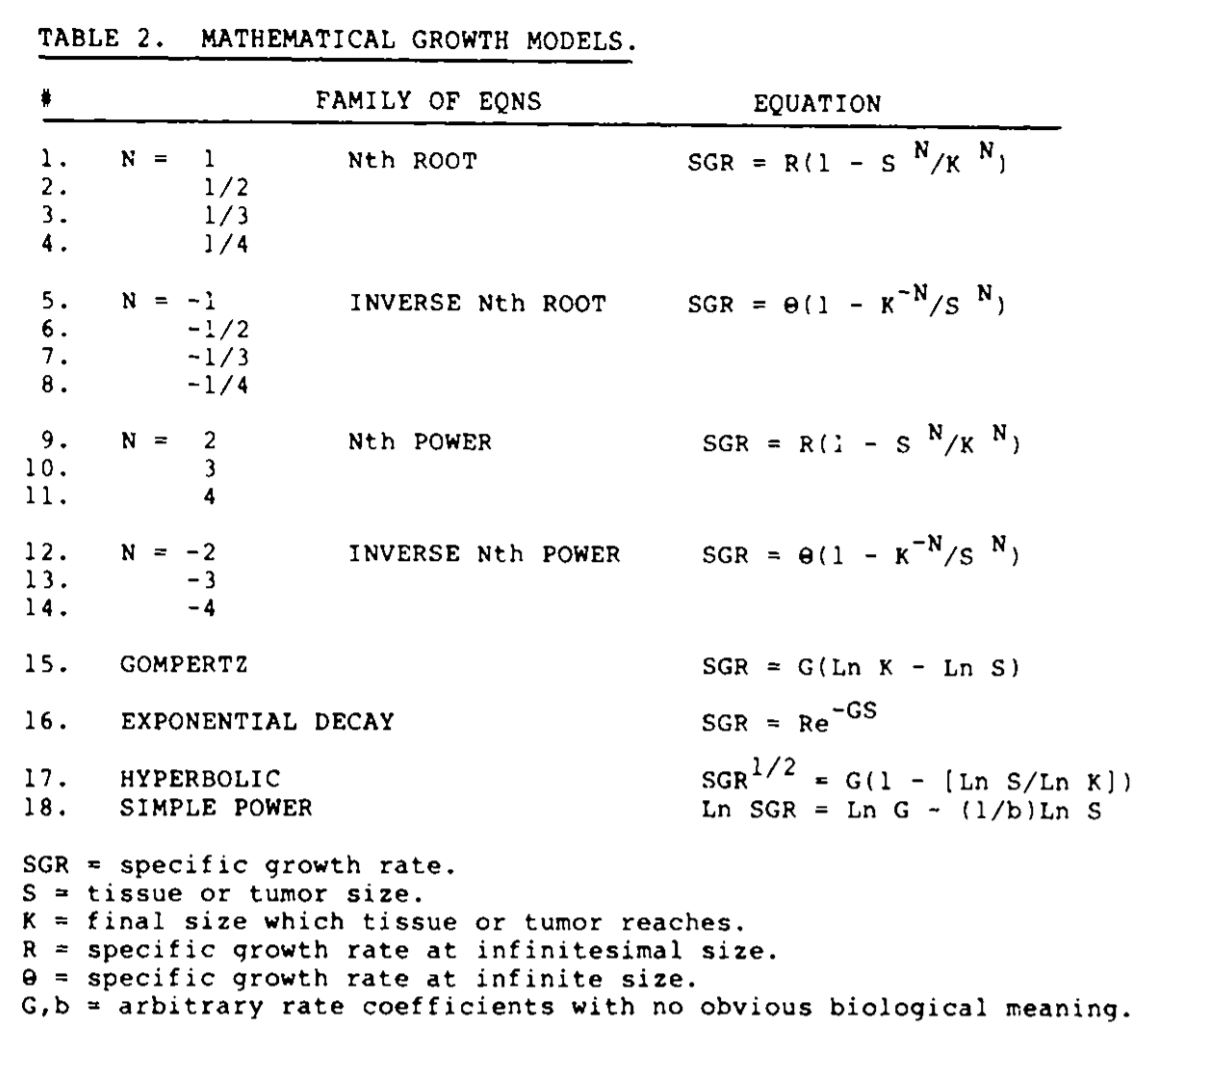
</div>

# Code

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.integrate import odeint



plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline

np.random.seed(123)

In [2]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'
tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,53.973689,19.464756,27.939597,19.032486,44.872119,20.290405,38.955318,21.359080,30.988742,17.752230,42.366388,13.069455
1,14,56.730533,34.316923,47.079148,26.709641,59.175717,41.133786,39.697439,29.993253,34.640653,25.398323,52.488467,23.978783
2,23,90.677211,51.384002,61.140151,31.821015,112.524376,51.204812,75.404253,68.348904,61.905680,33.892752,118.747997,71.618255
3,29,182.971051,96.268908,127.343047,61.519414,211.247381,127.305794,217.351729,153.788112,134.994293,65.107710,182.961115,103.520392
4,34,284.888364,147.891820,225.843888,92.229404,346.168185,147.788359,388.344451,247.451969,257.324806,123.482982,267.228868,140.192699


In [3]:
ts = np.array(tumor_size_db['Day']).reshape(-1,1)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

In [4]:
Ts_control = np.array(tumor_size_db[['G1_avg']]).transpose()
sigmas_control = np.array(tumor_size_db[['G1_sd']]).transpose()

Ts_dox = np.array(tumor_size_db[['G2_avg']]).transpose()
sigmas_dox = np.array(tumor_size_db[['G2_sd']]).transpose()

Ts_her = np.array(tumor_size_db[['G3_avg']]).transpose()
sigmas_her = np.array(tumor_size_db[['G3_sd']]).transpose()

Ts_combined = np.array(tumor_size_db[['G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas_combined = np.array(tumor_size_db[['G4_sd','G5_sd','G6_sd']]).transpose()



In [5]:
def unit(x):
    if x>=0: return 1
    return 0

def get_tt(tuple_treatment_group):
    switcher={
        ('dox',2): [39],
        
        ('her',3): [35,38],
        
        ('dox',4): [35],
        ('her',4): [36,39],
        
        ('her',5): [35,38],
        ('dox',5): [39],
        
        ('her',6): [35,38],
        ('dox',6): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])


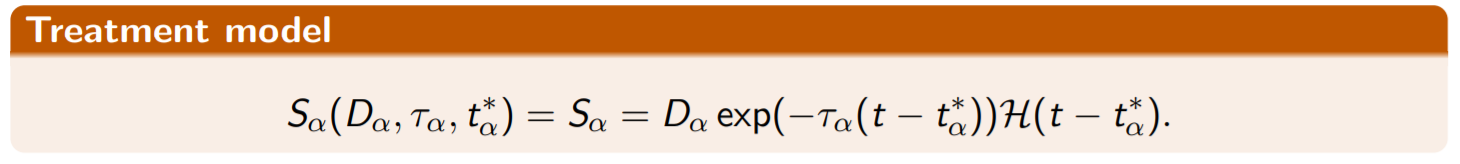

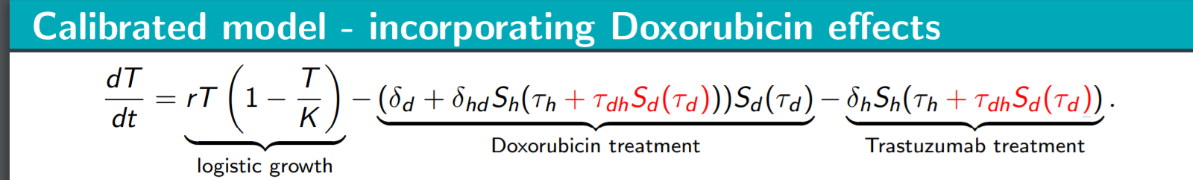

In [6]:

def get_Sd(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group+1))
        for tt in treatment_times:
            Sd[group] = Sd[group] + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group+1))
        for tt in treatment_times:
            tau = tau_h + tau_dh*Sd
            #print('tau_h ' + str(tau_h))
            #print('tau_dh ' + str(tau_dh))
            #print('Sd ' + str(Sd))
            #print('***group ' + str(group))
            #print('tau ' + str(tau))
            #print('t - tt ' + str(t-tt))
            #print('-tau[group]*(t-tt))')
            #print(-tau[group]*(t-tt))
            #print('exp')
            #print(np.exp(-tau[group]*(t-tt)))
            #print(np.exp(-tau[group]*(t-tt))*np.heaviside(t-tt, 0))
            
            # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
            # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
            # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
            Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0) 
    #print('Sh ' +str(Sh))
    return Sh


#### Treatment calculation unit tests

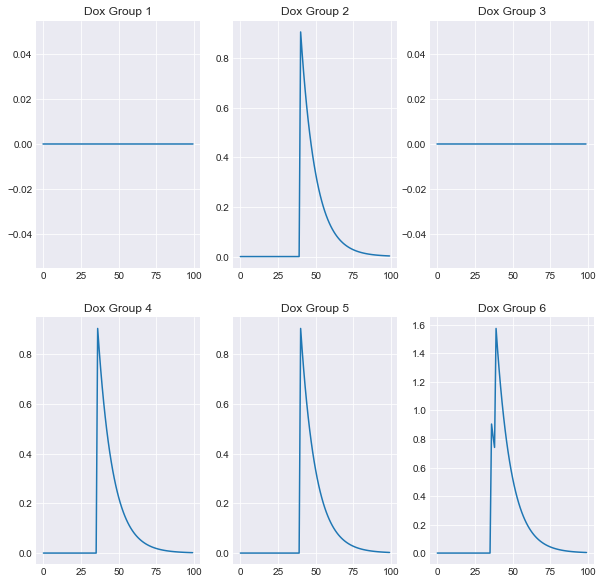

In [7]:

def test_treatment_Sd():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group + 1))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd()


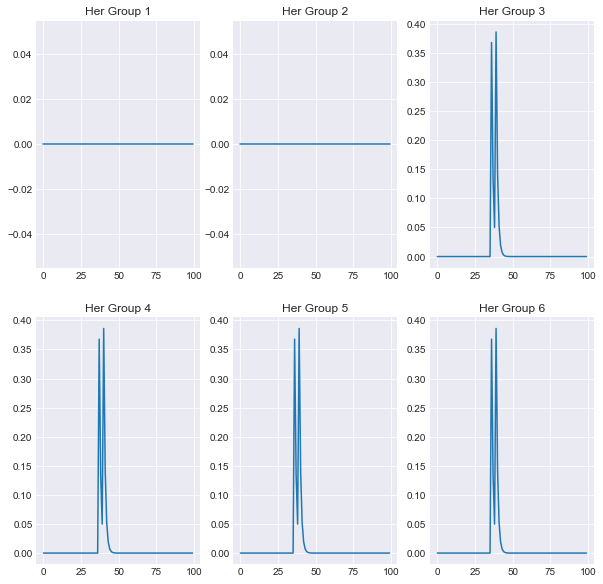

In [8]:

def test_treatment_Sh():
    tau_h=1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
        Shs[:,ii] = get_Sh(tau_h, tau_dh, Sds[:,ii], ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group + 1))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh()


In [9]:
sim_times = np.linspace(7,70,70-7+1)

def graph_sim(group_num, sim_times, T_sim):
    plt.figure(figsize=[4,2.5])
    #for ii in range(6):
    #    plt.subplot(2,3,ii+1)
    #    #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
    #    plt.errorbar(tumor_size_db['Day'], Ts[ii], sigmas[ii],fmt='.',capsize=2)
    #    plt.plot(sim_times, T_sim[ii])
    #    plt.title('G' + str(ii+1))
    #    plt.xlabel('Day')
    #    plt.ylabel('Size')
    ii = group_num-1
    plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(group_num)+'_avg'])
    plt.errorbar(tumor_size_db['Day'], Ts[ii], sigmas[ii],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim.transpose())
    plt.title('G' + str(group_num))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    

def graph_dox(sim_times, dox):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, dox[:,ii])
        plt.title('Dox ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()
    


def graph_her(sim_times, her):
    plt.figure(figsize=[16,10])
    for ii in range(6):
        plt.subplot(2,3,ii+1)
        #plt.scatter(tumor_size_db['Day'], tumor_size_db['G'+str(ii+1)+'_avg'])
        plt.plot(sim_times, her[:,ii])
        plt.title('her ' + str(ii+1))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()


def fit_sim_graph_model(model_class):
    this_model = model_class()
    this_model.backward()
    #delta_d, delta_h, tau_d, tau_h = this_model.get_treatment_params()
    #T_sim = this_model.simulate([this_model.get_param(x) for x in this_model.param_list])
    
    r, K = [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(r, K, sim_times)
    #dox = np.zeros((len(sim_times),6))
    #her = np.zeros((len(sim_times),6))
    #for ii in range(len(sim_times)):
    #    dox[ii] = get_Sd(tau_d, sim_times[ii])
    #    her[ii] = get_Sh(tau_h, tau_dh, dox[ii], sim_times[ii])
    graph_sim(1, sim_times, T_sim)
    #graph_dox(sim_times, dox)
    #graph_her(sim_times, her)
    
    print('r: ' + str(r))
    print('K: ' + str(K))
    
    return r, K

In [10]:

def rungeKutta(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((1, time_len))
    ret[:,0] = T0
    T = T0
    for i in range(1,time_len):
        T = T.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params) 
        k4 = h * dTdt(t+h, T + k3, params) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        #if np.float('-inf') in T: 
        #    print('divergence in rk')
        #    print('t0 ' + str(t0))
        #    print('t ' + str(t))
        #    print('h ' + str(h))
        #    print('k1 ' + str(k1))
        #    print('k2 ' + str(k2))
        #    print('k3 ' + str(k3))
        #    print('k4 '  + str(k4))
        #    print('T ' + str(T))
        #ret[:,i] = T.clip(min=0)
        ret[:,i] = max(T, 0)
    return ret

class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0

    def _simulate(self, params, times):
        values = rungeKutta(times, self._T0, self.dTdt, params)
        return values
   
    def get_param(self, param_name, n=5):
        return sum(self.trace[param_name][-n:])/n

    #def get_treatment_params(self):
    #    delta_d = self.get_param('delta_d')
    #    delta_h = self.get_param('delta_h')
    #    tau_d = self.get_param('tau_d')
    #    tau_h = self.get_param('tau_h')
    #    return [delta_d, delta_h, tau_d, tau_h]
    


## Drug drug interaction growth model

In [11]:
#import os
#os.environ["MKL_THREADING_LAYER"] = "GNU"  ## potential bug fix for slice, don't know if it matters anymore after solving divergence


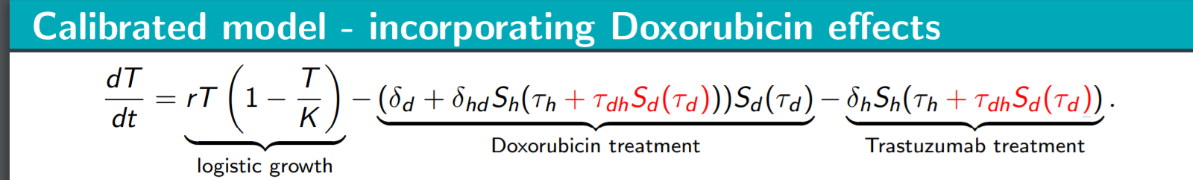

Only 200 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [r]
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:04<00:00, 59.86it/s]


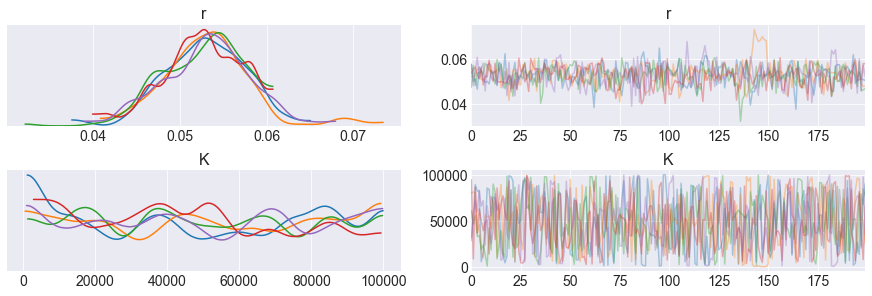

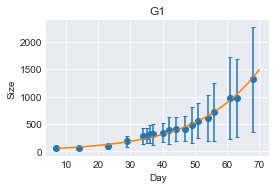

r: 0.05312897354540654
K: 53220.20126312423


In [57]:
class growth_model_natural(growth_model):
    def __init__(self):
        super().__init__(ts, Ts_control[0][0])
    
    def simulate(self, r, K, times=None):
        if times is None: times = self._times        
        return self._simulate([r, K], times)
    
    def dTdt(self, t, T, params):
        r, K = [x for x in params] 
         
        return T*r*(1-T/K)
    
    def backward(self):
        T_obs = Ts_control
        sigmas = sigmas_control
        with pm.Model():
            self.param_list = ['r', 'K']
            r_lower = 0.0
            r_upper = 0.1
            K_lower = 0.0
            K_upper = 100000
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            K = pm.Uniform('K', lower=K_lower, upper=K_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, K):
                th_states = self.simulate(r, K)
                return th_states
            
            forward = th_forward_model(r, K)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 5
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'K':np.random.uniform(K_lower, K_upper),                     
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
     

            
r, K = fit_sim_graph_model(growth_model_natural)

## Takeaway: there isn't enough logistic behavior to parameterize K. 
## exponential growth rate = 0.053 per day


Only 200 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [delta_h]
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:14<00:00, 16.91it/s]


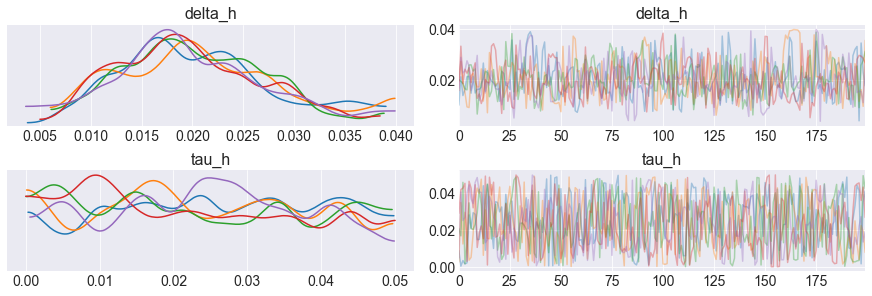

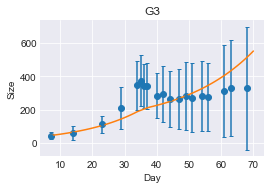

delta_h: 0.016620267011027624
tau_h: 0.01879572875213984


In [13]:

def fit_sim_graph_model(model_class):
    this_model = model_class()
    this_model.backward()
    delta_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(delta_h, tau_h, sim_times)
    graph_sim(3, sim_times, T_sim)
        
    print('delta_h: ' + str(delta_h))
    print('tau_h: ' + str(tau_h))

    return delta_h, tau_h


def get_Sh_group3(tau_h, t):
    Sh = 0
    treatment_times = get_tt(('her', 3))
    for tt in treatment_times:
        Sh = Sh + np.exp(-tau_h*(t-tt))*np.heaviside(t-tt, 0)
    return Sh


"""def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group+1))
        for tt in treatment_times:
            tau = tau_h + tau_dh*Sd
            Sh[group] = Sh[group] + np.exp(-tau[group]*(t-tt))*np.heaviside(t-tt, 0)
    return Sh
    """

class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, Ts_her[0][0])
    
    def simulate(self, delta_h, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_h, tau_h], times)
    
    def dTdt(self, t, T, params):
        delta_h, tau_h = [x for x in params] 
        Sh = get_Sh_group3(tau_h, t)
        r = 0.05312897354540654
        return T*r - T*delta_h*Sh
    
    def backward(self):
        T_obs = Ts_her
        sigmas = sigmas_her
        with pm.Model():
            self.param_list = ['delta_h', 'tau_h']
            
            delta_h_lower = 0.0
            delta_h_upper = 0.04
            
            tau_h_lower = 0.0
            tau_h_upper = 0.05
            
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_h, tau_h):
                th_states = self.simulate(delta_h, tau_h)
                return th_states
            
            forward = th_forward_model(delta_h, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 5
            startsmc=[{'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 

            
delta_h, tau_h = fit_sim_graph_model(growth_model_her)



## Ernesto's Findings

delta_h = 0.03165840

tau_h = 0.01696031


## My findings

delta_h = 0.01662

tau_h = 0.018795



## The growth needs to be stronger here. Delta shows good convergence but tau_h does not


## Fitting dox model 1: No HER interaction

Only 200 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Slice: [tau_d]
>Slice: [delta_d]
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:07<00:00, 25.07it/s]


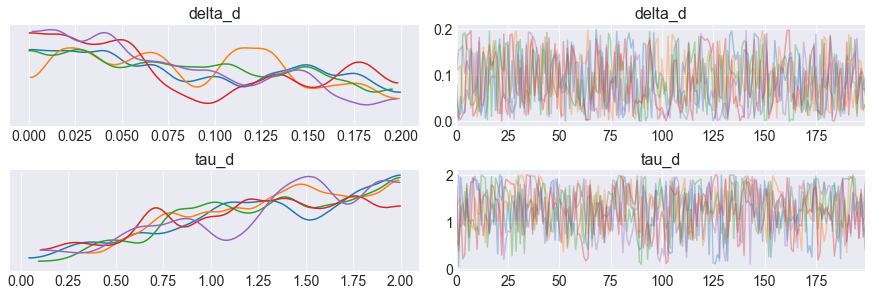

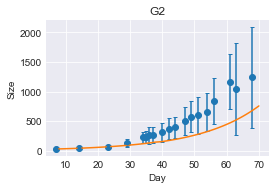

delta_d: 0.07106051056074567
tau_d: 1.1829779383228092


In [13]:

def fit_sim_graph_model(model_class):
    this_model = model_class()
    this_model.backward()
    delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(delta_d, tau_d, sim_times)
    graph_sim(2, sim_times, T_sim)
        
    print('delta_d: ' + str(delta_d))
    print('tau_d: ' + str(tau_d))

    return delta_d, tau_d


def get_Sd_group2(tau_d, t):
    Sd = 0
    treatment_times = get_tt(('dox',2))
    for tt in treatment_times:
        Sd = Sd + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd



class growth_model_dox(growth_model):
    def __init__(self):
        super().__init__(ts, Ts_dox[0][0])
    
    def simulate(self, delta_d, tau_d, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_d, tau_d], times)
    
    def dTdt(self, t, T, params):
        delta_d, tau_d = [x for x in params] 
        Sd = get_Sd_group2(tau_d, t)
        r = 0.05312897354540654
        return T*r - T*delta_d*Sd
    
    
    
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = 0 
            delta_d_upper = 0.2
            
            tau_d_lower = 0
            tau_d_upper = 2
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 5
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 

            
delta_d, tau_d = fit_sim_graph_model(growth_model_dox)



## Ernesto's Findings

delta_d = 6.548050e-05

tau_d = 3.001805e-01


## My findings

delta_d: 0.12671758528146543


tau_d: 0.5353287922846124

## Takeaway: doxorubicin must be fit after trastuzumab
### We will fit group 3, and then we will fit groups 2, 4, 5, and 6 together

In [59]:
class growth_model_dd_interaction(growth_model):  
    
    def simulate(self, r, K, delta_d, delta_h, delta_dh, tau_d, tau_h, tau_dh, times=None):
        if times is None: times = self._times        
        return self._simulate([r, K, delta_d, delta_h, delta_dh, tau_d, tau_h, tau_dh], times)
    
    def dTdt(self, t, T, params):
        delta_dh, tau_dh = [x for x in params] 
           
        def get_her_treatment(delta_h, Sh):
            return delta_h*Sh

        def get_dox_treatment(delta_d, delta_dh, Sh):
            return (delta_d+delta_dh*Sh)*Sd
        
        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
        
        her = get_her_treatment(Sd, Sh)
        dox = get_dox_treatment(delta_d, delta_dh, Sh)
        
        
        return r*T - T*dox - T*her
    
    def backward(self, T_obs, sigmas):
        Ts_obs = Ts_combined 
        sigmas = sigmas_combined
        with pm.Model():
            self.param_list = ['r', 'K', 'delta_d', 'delta_h', 'delta_dh', 'tau_d', 'tau_h', 'tau_dh']
            delta_dh_lower = 0
            delta_dh_upper = 5
            tau_dh_lower = 0
            tau_dh_upper = 1

            delta_dh = pm.Uniform('delta_dh', lower=delta_dh_lower, upper=delta_dh_upper)
            tau_dh = pm.Uniform('tau_dh', lower=tau_dh_lower, upper=tau_dh_upper)
            

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_dh, tau_dh):
                th_states = self.simulate(delta_dh, tau_dh)
                return th_states
            
            forward = th_forward_model(delta_dh, tau_dh)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 1
            startsmc=[{'delta_dh':np.random.uniform(delta_dh_lower, delta_dh_upper),
                       'tau_dh':np.random.uniform(tau_dh_lower, tau_dh_upper),   
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            self.trace = pm.sample(num_samples, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
     

            
fit_sim_graph_model(growth_model_dd_interaction)


"\nclass growth_model_dd_interaction(growth_model):  \n    \n    def simulate(self, r, K, delta_d, delta_h, delta_dh, tau_d, tau_h, tau_dh, times=None):\n        if times is None: times = self._times        \n        return self._simulate([r, K, delta_d, delta_h, delta_dh, tau_d, tau_h, tau_dh], times)\n    \n    def dTdt(self, t, T, params):\n        r, K, delta_d, delta_h, delta_dh, tau_d, tau_h, tau_dh = [x for x in params] \n           \n        def get_her_treatment(delta_h, Sh):\n            return delta_h*Sh\n\n        def get_dox_treatment(delta_d, delta_dh, Sh):\n            return (delta_d+delta_dh*Sh)*Sd\n        \n        Sd = get_Sd(tau_d, t)\n        Sh = get_Sh(tau_h, tau_dh, Sd, t)\n        \n        her = get_her_treatment(Sd, Sh)\n        dox = get_dox_treatment(delta_d, delta_dh, Sh)\n        \n        \n        return r*T - dox - her\n    \n    def backward(self, T_obs, sigmas):\n        with pm.Model():\n            self.param_list = ['r', 'K', 'delta_d', 'delta_h'

## Verify Ernesto's Work


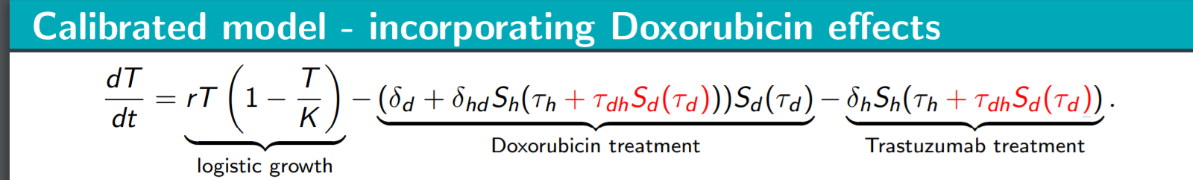

Ernesto's Parameters

r = 6.773495e-02
k = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
tau_dh = 9.344758e+03

In [98]:
0*np.float("inf")

nan

In [12]:
def get_Sd(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group+1))
        for tt in treatment_times:
            Sd[group] = Sd[group] + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group+1))
        for tt in treatment_times:
            if t > tt:
                tau = tau_h + tau_dh*Sd
                #print('tau_h ' + str(tau_h))
                #print('tau_dh ' + str(tau_dh))
                #print('Sd ' + str(Sd))
                #print('***group ' + str(group))
                #print('tau ' + str(tau))
                #print('t - tt ' + str(t-tt))
                #print('-tau[group]*(t-tt))')
                #print(-tau[group]*(t-tt))
                #print('exp')
                #print(np.exp(-tau[group]*(t-tt)))
                #print(np.exp(-tau[group]*(t-tt))*np.heaviside(t-tt, 0))
                #Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0)
                Sh[group] = Sh[group] + np.exp(-tau[group]*(t-tt))
                
    #print('Sh ' +str(Sh))
    return Sh


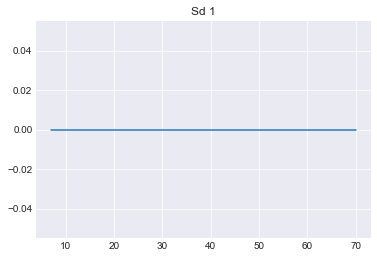

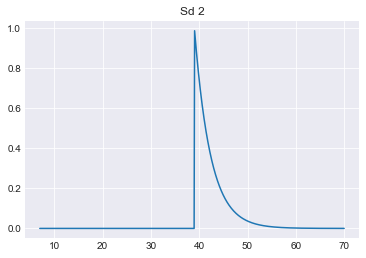

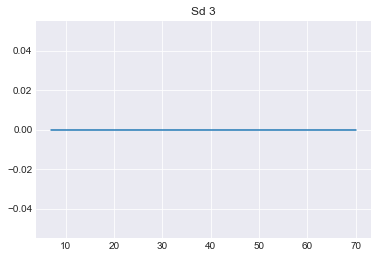

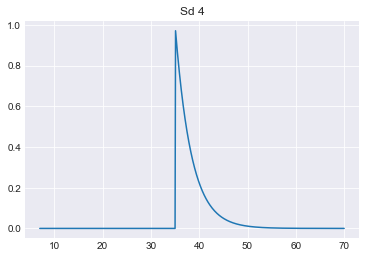

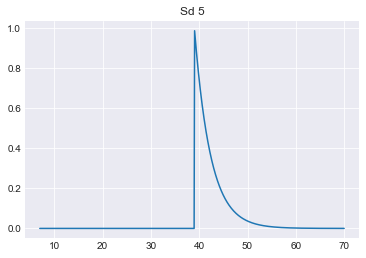

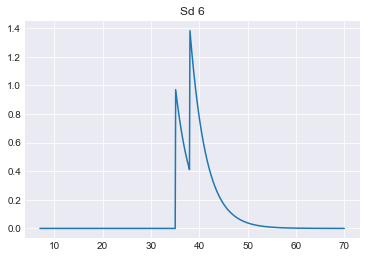

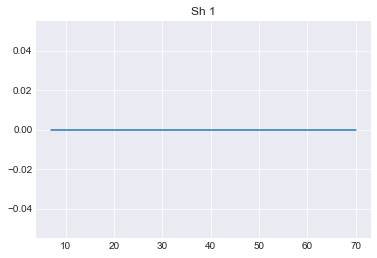

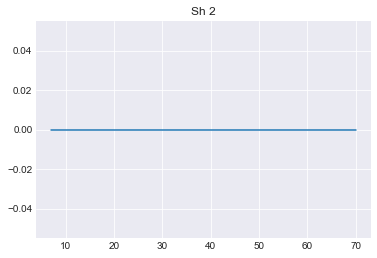

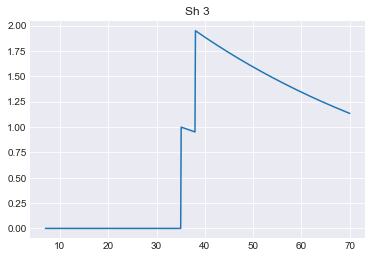

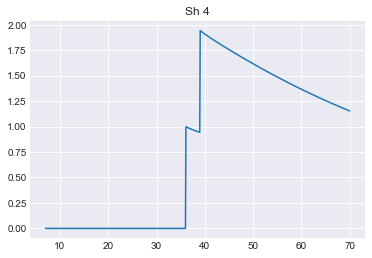

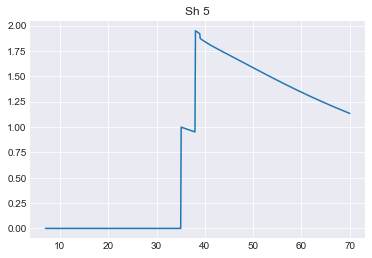

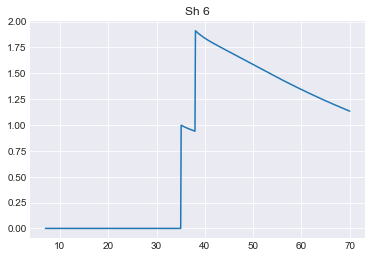

In [13]:
r = 6.773495e-02
K = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
#tau_dh = 9.344758e+03
tau_dh = 9.344758e-03

sim_times = np.linspace(7,70,10*(70-7+1))

Sds = np.zeros((6,len(sim_times)))
Shs = np.zeros((6,len(sim_times)))

for ii in range(len(sim_times)):
    t = sim_times[ii]
    Sd = get_Sd(tau_d, t)
    Sds[:, ii] = Sd
    Sh = get_Sh(tau_h, tau_dh, Sd, t)
    Shs[:, ii] = Sh

for ii in range(6):
    plt.figure()
    plt.title('Sd ' + str(ii+1))
    plt.plot(sim_times, Sds[ii,:])
    plt.show()
    
for ii in range(6):
    plt.figure()
    plt.title('Sh ' + str(ii+1))
    plt.plot(sim_times, Shs[ii,:])
    plt.show()

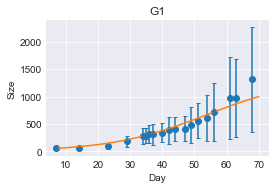

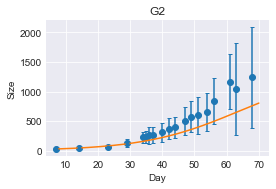

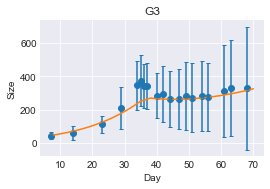

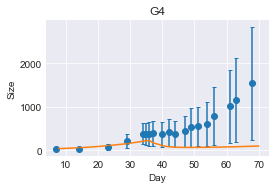

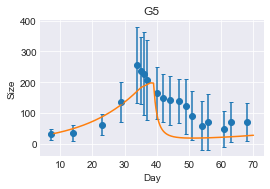

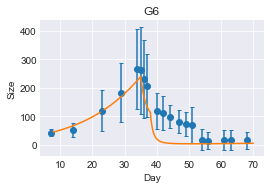

In [18]:
sim_times = np.linspace(7,70,100*(70-7+1))

import math

def check_nan(x):
    is_nan = False
    for ii in range(len(x)):
        is_nan = is_nan or np.isnan(np.float(x[ii]))
    return is_nan

def rungeKutta(ts, T0, dTdt, params=None): 
    time_len = len(ts.ravel())
    ret = np.zeros((6, time_len))
    ret[:,0] = T0
    T = T0
    for i in range(1,time_len):
        T = T.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params) 
        k4 = h * dTdt(t+h, T + k3, params) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        #if np.float('-inf') in T: 
        #    print('divergence in rk')
        #    print('t0 ' + str(t0))
        #    print('t ' + str(t))
        #    print('h ' + str(h))
        #    print('k1 ' + str(k1))
        #    print('k2 ' + str(k2))
        #    print('k3 ' + str(k3))
        #    print('k4 '  + str(k4))
        #    print('T ' + str(T))
        #ret[:,i] = T.clip(min=0)
        """
        if check_nan(T):
            print('T is nan')
            print('t: ' + str(t))
            print('T: ' + str(T))
            print('k1 ' + str(k1))
            print('k2 ' + str(k2))
            print('k3 ' + str(k3))
            print('k4 '  + str(k4))
        if t==34:
            print('t: ' + str(t))
            print('T: ' + str(T))
            print('k1 ' + str(k1))
            print('k2 ' + str(k2))
            print('k3 ' + str(k3))
            print('k4 '  + str(k4))
        """
        T[T<0] = 0
        ret[:,i] = T
    return ret

def sim_graph_model(model_class):
    this_model = model_class()
    #this_model.backward()
    #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
    T_sim = this_model.simulate(sim_times)
    graph_sim(1, sim_times, T_sim[0,:])
    graph_sim(2, sim_times, T_sim[1,:])
    graph_sim(3, sim_times, T_sim[2,:])
    graph_sim(4, sim_times, T_sim[3,:])
    graph_sim(5, sim_times, T_sim[4,:])
    graph_sim(6, sim_times, T_sim[5,:])
    return T_sim


class growth_model_final(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, times):
        values = rungeKutta(times, self._T0, self.dTdt)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times        
        return self._simulate(times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        #tau_dh = 9.344758e+03
        tau_dh = 9.344758e-03
        
        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        #r = 0.05312897354540654
        
        #ret =  r*T*(1-T/K) - (delta_d + delta_dh * Sh)*Sd*T - T*delta_h*Sh
        ret =  r*T*(1-T/K) - T*(delta_d + delta_dh * Sh)*Sd - T*delta_h*Sh
        
        """
        if 34<= t and t <= 40:
            print('**********At time ' + str(t))
            print('Sd: ')
            print(Sd)
            print('Sd shape')
            print(Sd.shape)
            print('Sh')
            print(Sh)
            print('Sh shape')
            print(Sh.shape)
            print('middle term')
            print(0-(delta_d + delta_dh * Sh)*Sd)
            print('middle term shape')
            print((0-(delta_d + delta_dh * Sh)*Sd).shape)
            print('DTdt')
            print(ret)
        """
        
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
        
            
T_sim = sim_graph_model(growth_model_final)
